In [1]:
import numpy as np
import keras
from keras.models import load_model
import csv
from createdatas import gaussian_beam, createdata
import datetime
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit    # フィッティング用
date = str(datetime.date.today())
NOISE = 80 #学習noise%
MAX = 10 #上限%
print(NOISE)
print(date)

Using TensorFlow backend.


80
2020-10-27


In [5]:
#　テストデータ取得
file_num = 20 #テストファイル数20
test_num = 101 #データ数(0%~100%)
data_size = 100 #配列の大きさ

t_101 = np.zeros((file_num ,test_num))
x_101 = np.zeros((file_num, test_num, data_size))
n = range(0, file_num)
test_nums = range(0, test_num)

def _testdata(x, t):
    for k in n:
        
        for key in test_nums:
            file_path = "/Users/nagaiyuma/Desktop/10%/" + str(n[k]) + "/x_" + str(test_nums[key]) + ".txt"
            with open(file_path) as f:
                file_str = f.read().splitlines()
                f.close

            for i in range(0, data_size):
                x[k][key][i] = float(file_str[i])

        for key in test_nums:
            file_path = "/Users/nagaiyuma/Desktop/10%/" + str(n[k]) + "/t_" + str(test_nums[key]) + ".txt"
            with open(file_path) as f:
                file_str = f.read()
                f.close

            t[k][key] = float(file_str)

    return x, t


_testdata(x_101, t_101)

print(x_101.shape)
print(t_101.shape)

(20, 101, 100)
(20, 101)


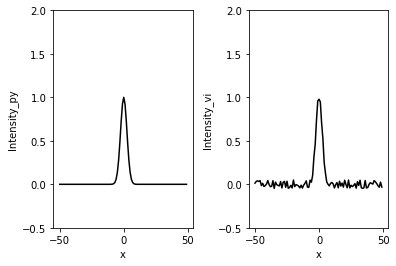

In [6]:
#表示
x_array = np.arange(-50, 50, 1.0)   
plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.subplot(1,2,1)
plt.plot(x_array, x_101[0][0],  color="black", label = 'x0 = 0.0')
plt.xlabel('x')          # 軸ラベル
plt.ylabel('Intensity_py')
plt.ylim(-0.5, 2.0)      # y軸の表示範囲
plt.subplot(1,2,2)
plt.plot(x_array, x_101[0][100],  color="black", label = 'x0 = 0.0')
plt.xlabel('x')          # 軸ラベル
plt.ylabel('Intensity_vi')
plt.ylim(-0.5, 2.0)
plt.show()
plt.close()

In [7]:
#学習パラメータの取得
pred_x = np.zeros((file_num ,test_num))
save_model_path = "/Users/nagaiyuma/Desktop/parameters/noise"+str(NOISE)+"-cnn1.h5"
model = load_model(save_model_path)

In [8]:
ave_101 = np.zeros(test_num)
std_101 = np.zeros(test_num)
error = np.zeros((file_num, test_num))
abs_error = np.zeros((file_num, test_num))

for k in n:
    xtest = x_101[k].reshape(-1, 100, 1)
    pred_x[k] = model.predict(xtest).flatten()
    error[k] = pred_x[k] - t_101[k]
    abs_error[k] = abs(pred_x[k] - t_101[k])
    
print(pred_x.shape)
ave_101 = np.average(error, axis=0)
std_101 = np.std(error, axis=0)

(20, 101)


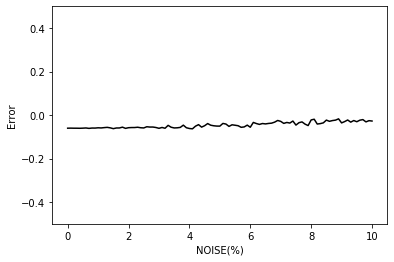

0.0%:-0.06034153699874878±0.0
1.0%:-0.0584841787815094±0.005720372464685688
2.0%:-0.05805434286594391±0.01188437867689708
3.0%:-0.060863366723060607±0.019305046452213356
4.0%:-0.061732086539268496±0.01919626666465463
5.0%:-0.05078352093696594±0.020855519286195542
6.0%:-0.0559151828289032±0.03457562085113758
7.0%:-0.028924062848091125±0.023845967927950837
8.0%:-0.022301545739173888±0.041581688350577975
9.0%:-0.03593024313449859±0.03551486765603096
10.0%:-0.027411481738090514±0.0530025991629494


In [9]:
#結果の表示
x = np.arange(0, 10.1,0.1)
plt.plot(x, ave_101,  color="black")
plt.xlabel('NOISE(%)')          # 軸ラベル
plt.ylabel('Error')
plt.ylim(-0.5, 0.5)
plt.show()
plt.close()

for i in range(0,test_num,10):
    print_ave = str(x[i]) + "%:" + str(ave_101[i])+ "±" + str(std_101[i])
    print(print_ave)

In [10]:
#結果の保存
save_predict = "/Users/nagaiyuma/Desktop/maindata/"+date+"noise%d_%dvi.csv" %(NOISE, MAX)
save_data = np.zeros((3, test_num))
save_data[0] = x
save_data[1] = ave_101
save_data[2] = std_101
save_data = save_data.T

with open(save_predict,'w') as f:
    writer = csv.writer(f, lineterminator='\n')
    writer.writerows(save_data)

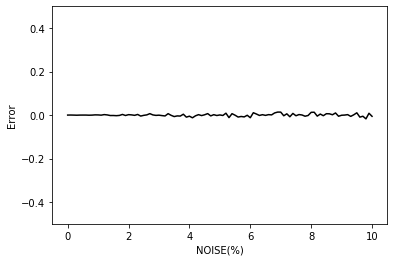

0.0%:-4.4171386496305376e-17±1.232595164407831e-32
1.0%:0.0006981476012021311±0.004600985976490515
2.0%:0.0019746058784526695±0.008800230517500474
3.0%:-0.00041892834737990403±0.014606179287369965
4.0%:-0.005072657443146022±0.017490391910446594
5.0%:0.0006333775757125453±0.024910794134494457
6.0%:-0.012149335694412653±0.03543080533646389
7.0%:0.01367237689886612±0.03199331627574566
8.0%:0.01259979456774048±0.0382838227047113
9.0%:-0.0007473352081443531±0.040112594163339725
10.0%:-0.005675943649089586±0.04369479922391404


In [11]:
# ガウシアンビームのパラメータ
i0 = 1.0
x0 = 0.0
y0 = 0.0
w0 = 5.0
h0 = 0.0
center = data_size/2
param_ini_x = np.array([i0, x0, w0, h0])  # フィッティングの初期値 (ここではデータから推定は行わない)
x_array = np.arange(-center, center, 1.0)
fit_param_x = np.zeros((test_num, 4))
error = np.zeros((file_num, test_num))

t_fit = t_101 - 1 #x = 0の補正
for i in range(file_num):
    for k in range(test_num):
        profile_x = x_101[i][k]
        param, cov  = curve_fit(gaussian_beam, x_array, profile_x, p0=param_ini_x, maxfev=2000)
        fit_param_x[n][0] = param[0]
        fit_param_x[n][1] = param[1]
        fit_param_x[n][2] = param[2]
        fit_param_x[n][3] = param[3]
        
        error[i][k] = param[1]-t_fit[i][k]
    
ave_fit = np.average(error, axis=0)
std_fit= np.std(error, axis=0)

#結果の表示
plt.plot(x, ave_fit,  color="black")
plt.xlabel('NOISE(%)')          # 軸ラベル
plt.ylabel('Error')
plt.ylim(-0.5, 0.5)
plt.show()
plt.close()

for i in range(0,test_num,10):
    print_ave = str(x[i]) + "%:" + str(ave_fit[i])+ "±" + str(std_fit[i])
    print(print_ave)

In [12]:
#結果の保存
save_predict = "/Users/nagaiyuma/Desktop/maindata/"+date+"-%d_fitvi.csv" %(MAX)
x_line = n
save_data = np.zeros((3, test_num))
save_data[0] = x
save_data[1] = ave_fit
save_data[2] = std_fit
save_data = save_data.T

with open(save_predict,'w') as f:
    writer = csv.writer(f, lineterminator='\n')
    writer.writerows(save_data)

In [13]:
#学習パラメータの取得
pred_x = np.zeros((file_num ,test_num))
save_model_path = "/Users/nagaiyuma/Desktop/parameters/noise"+str(NOISE)+"-cnn3.h5"
model = load_model(save_model_path)

In [14]:
ave_101_3 = np.zeros(test_num)
std_101_3 = np.zeros(test_num)
error = np.zeros((file_num, test_num))
abs_error = np.zeros((file_num, test_num))

for k in n:
    xtest = x_101[k].reshape(-1, 100, 1)
    pred_x[k] = model.predict(xtest).T[1].flatten()
    error[k] = pred_x[k] - t_101[k]
    abs_error[k] = abs(pred_x[k] - t_101[k])

ave_101_3 = np.average(error, axis=0)
std_101_3 = np.std(error, axis=0)

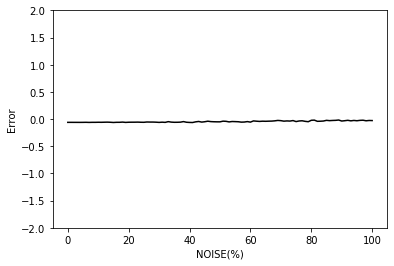

0.0%:-0.07143962383270264±0.0
1.0%:-0.07169510126113891±0.0027020180419208236
2.0%:-0.07091214656829833±0.004616616530699088
3.0%:-0.07542237639427185±0.009733388855251537
4.0%:-0.07686548233032227±0.008663161204696693
5.0%:-0.07710132002830505±0.012629167159632578
6.0%:-0.08164955377578735±0.017738263515736864
7.0%:-0.06942346096038818±0.018314879690590737
8.0%:-0.07363920509815217±0.021075917603110773
9.0%:-0.076816987991333±0.020291829368478096
10.0%:-0.08521420061588288±0.02640378770792124


In [15]:
#結果の表示
plt.plot(test_nums, ave_101,  color="black")
plt.xlabel('NOISE(%)')          # 軸ラベル
plt.ylabel('Error')
plt.ylim(-2.0, 2.0)
plt.show()
plt.close()

for i in range(0,test_num,10):
    print_ave = str(x[i]) + "%:" + str(ave_101_3[i])+ "±" + str(std_101_3[i])
    print(print_ave)

In [16]:
#結果の保存
save_predict = "/Users/nagaiyuma/Desktop/maindata/"+date+"noise%d-%d_3vi.csv" %(NOISE, MAX)
save_data = np.zeros((3, test_num))
save_data[0] = x
save_data[1] = ave_101_3
save_data[2] = std_101_3
save_data = save_data.T

with open(save_predict,'w') as f:
    writer = csv.writer(f, lineterminator='\n')
    writer.writerows(save_data)